In [26]:
import numpy as np
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report,roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [2]:
dir_path = 'Garbage classification'
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))
len(img_list)

2527

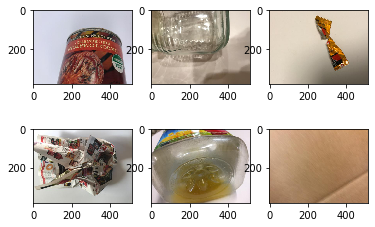

In [3]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

### Image Augmentation 

In [4]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(300,300),
                                          batch_size=16,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(dir_path,
                                        target_size=(300,300),
                                        batch_size=16,
                                        class_mode='categorical',
                                        subset='validation')

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [5]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((16, 300, 300, 3), (16, 6))

In [6]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(Labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [7]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model

### Convolutional Neural Network

In [8]:
model=Sequential()
#Convolution blocks

model.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))
#model.add(SpatialDropout2D(0.5))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

filepath="cnn_checkpoint.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43808)            

In [9]:
model.compile(loss='categorical_crossentropy', # loss function used for classes that are greater than 2)
              optimizer='adam', 
              metrics=['acc'])

In [10]:
history = model.fit_generator(train_generator,
                              epochs = 20,
                              steps_per_epoch = 2276//16,
                              validation_data = test_generator,
                              validation_steps = 251//16,
                              workers = 4,
                              callbacks=callbacks_list) 

Epoch 1/20
142/142 [==============================] - 105s 740ms/step - loss: 1.7778 - acc: 0.2044 - val_loss: 1.6966 - val_acc: 0.2333

Epoch 00001: val_acc improved from -inf to 0.23333, saving model to cnn_checkpoint.h5
Epoch 2/20
142/142 [==============================] - 104s 733ms/step - loss: 1.7150 - acc: 0.2265 - val_loss: 1.3675 - val_acc: 0.2553

Epoch 00002: val_acc improved from 0.23333 to 0.25532, saving model to cnn_checkpoint.h5
Epoch 3/20
142/142 [==============================] - 105s 738ms/step - loss: 1.5971 - acc: 0.3221 - val_loss: 1.3775 - val_acc: 0.3617

Epoch 00003: val_acc improved from 0.25532 to 0.36170, saving model to cnn_checkpoint.h5
Epoch 4/20
142/142 [==============================] - 104s 729ms/step - loss: 1.4233 - acc: 0.4177 - val_loss: 1.2031 - val_acc: 0.4043

Epoch 00004: val_acc improved from 0.36170 to 0.40426, saving model to cnn_checkpoint.h5
Epoch 5/20
142/142 [==============================] - 106s 743ms/step - loss: 1.3640 - acc: 0.4544 

In [13]:
with open('cnn.pickle', 'wb') as f:
    pickle.dump(model, f)

In [14]:
from tensorflow.keras.models import load_model

In [15]:
#save entire model to a HDF5 file
model.save('mlp_entire_model.h5')

In [16]:
#Recreate the exact same model, including weights and optimizer
# model = keras.models.load_model('mlp_entire_model.h5')

In [17]:
cnn_result=pd.DataFrame(history.history)
cnn_result

,val_loss,val_acc,loss,acc
0,1.696578,0.233333,1.777339,0.204425
1,1.367529,0.255319,1.714456,0.226549
2,1.377540,0.361702,1.595233,0.322124
3,1.203121,0.404255,1.426741,0.417699
4,1.089756,0.412766,1.365646,0.454425
5,1.318413,0.421277,1.340003,0.457522
6,1.404320,0.446809,1.285794,0.480531
7,1.282485,0.493617,1.302324,0.475664
8,1.350130,0.451064,1.264113,0.513717
9,1.463445,0.497872,1.234111,0.525664


In [18]:
cnn_result.to_csv('cnn.csv')

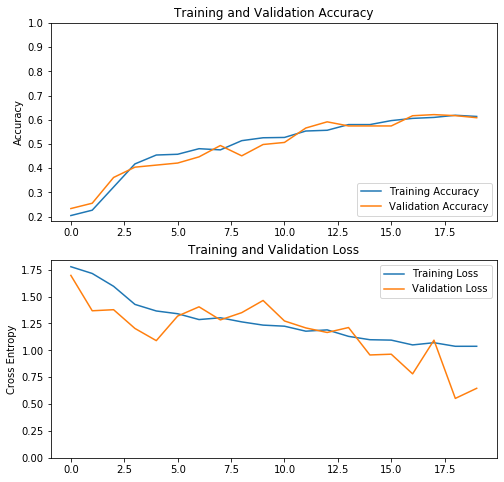

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

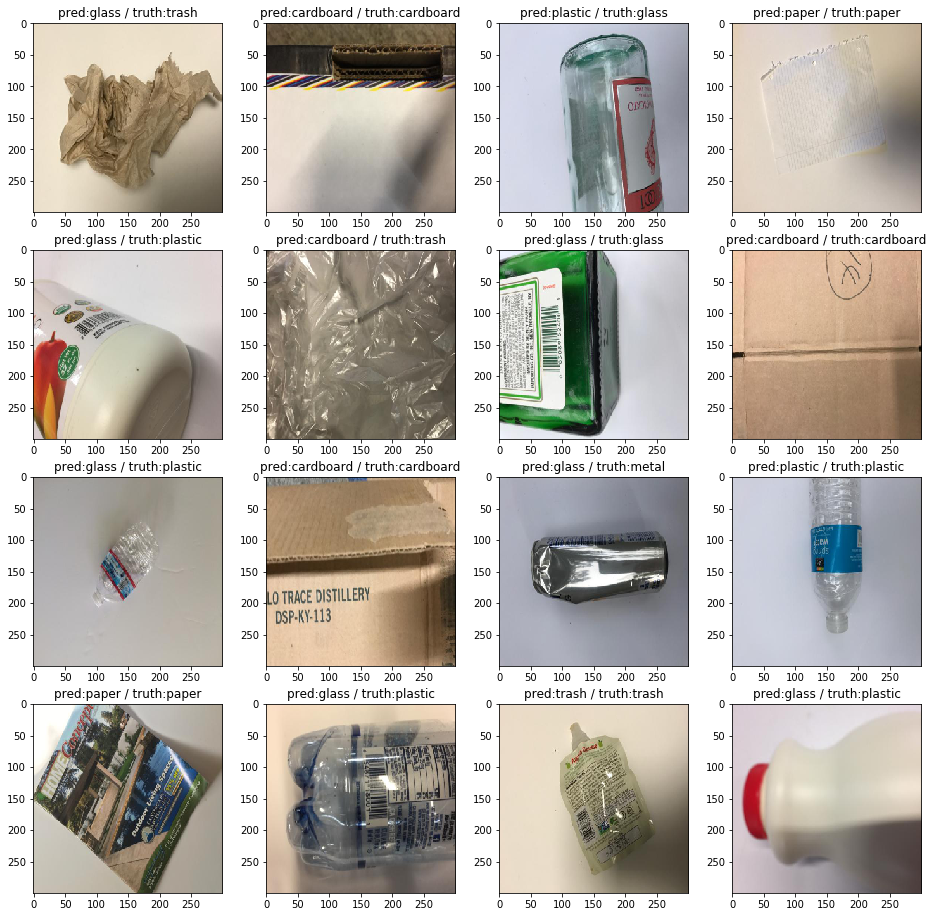

In [21]:
### Sample Test Results
test_x, test_y = test_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

In [22]:
y_pred=[]
y_test=[]
score = []
for j in range(16):
    test_x, test_y = test_generator.__getitem__(j)
    preds = model.predict(test_x)
    for i in range(len(test_y)):
        p = np.argmax(preds[i])
        t = np.argmax(test_y[i])
        s = preds[i]
        y_pred.append(p)
        y_test.append(t)
        score.append(s)
    if len(test_y)==16:
        print('1 batch predicted...')
    else:
        print('finish!')

1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
1 batch predicted...
finish!


In [23]:
score = pd.DataFrame(score,columns=labels.values())
score.to_csv('MLP_score.csv')
score.head()

,cardboard,glass,metal,paper,plastic,trash
0,0.003376,0.197121,0.499045,0.010891,0.171186,0.118381
1,0.132675,0.259532,0.140995,0.176962,0.166969,0.122868
2,0.009642,0.090465,0.020165,0.012463,0.866887,0.000378
3,0.000303,0.833440,0.145845,0.000381,0.019419,0.000612
4,0.001409,0.816521,0.136585,0.004375,0.040707,0.000402


In [24]:
y_dummy = pd.get_dummies(y_test)
y_dummy.head()

,0,1,2,3,4,5
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,1,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [27]:
report = classification_report(y_test,y_pred,target_names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])
print(report)

              precision    recall  f1-score   support

   cardboard       0.80      0.82      0.81        40
       glass       0.41      0.66      0.51        50
       metal       0.62      0.49      0.55        41
       paper       0.80      0.83      0.82        59
     plastic       0.54      0.29      0.38        48
       trash       0.45      0.38      0.42        13

    accuracy                           0.61       251
   macro avg       0.61      0.58      0.58       251
weighted avg       0.63      0.61      0.61       251



In [28]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[33  3  2  1  0  1]
 [ 1 33  7  2  5  2]
 [ 1 11 20  3  3  3]
 [ 1  6  0 49  3  0]
 [ 3 23  2  6 14  0]
 [ 2  4  1  0  1  5]]


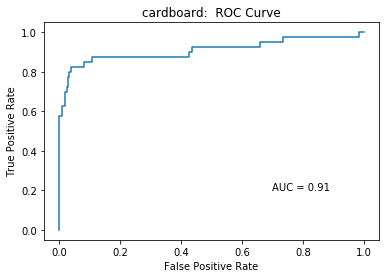

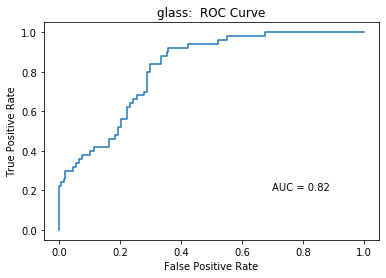

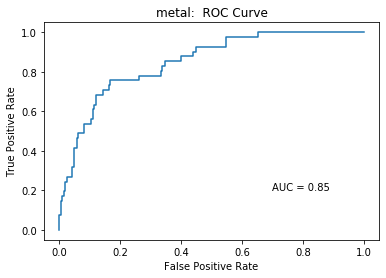

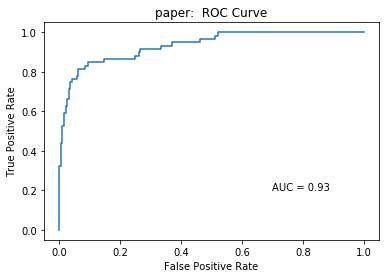

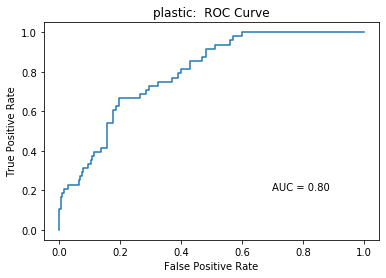

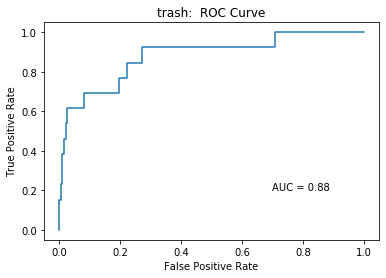

In [29]:
auc_result=[]
for i in range(6):
    fpr, tpr, thresholds  =  roc_curve(y_dummy.iloc[:,i],score.iloc[:,i]) 
    auc_score =auc(fpr, tpr) 
    auc_result.append(auc_score)
    plt.plot(fpr, tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(str(labels[i])+':  ROC Curve')
    plt.text(0.7,0.2,'AUC = %0.2f' % auc_score)
    plt.show()

In [30]:
c = {'label':score.columns.tolist(),'AUC':auc_result}
c = pd.DataFrame(c)
c

,label,AUC
0,cardboard,0.908531
1,glass,0.818109
2,metal,0.849361
3,paper,0.933351
4,plastic,0.795053
5,trash,0.879444


Maximum Probability:  0.93068683
Classified: plastic


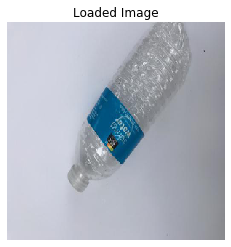

In [31]:
from keras.preprocessing import image

img_path = 'Garbage classification/plastic/plastic75.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p = model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

Individual Probability: 

CARDBOARD : 0.27 %
GLASS : 5.27 %
METAL : 0.98 %
PAPER : 0.4 %
PLASTIC : 93.07 %
TRASH : 0.01 %


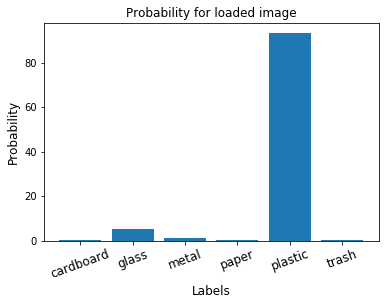

In [32]:
classes=[]
prob=[]
print("Individual Probability: \n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()